In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def load_and_mean(file_path, var):
    """
    Load a dataset from a NetCDF file and compute the mean for a specified variable.
    
    Parameters:
        file_path (str): Path to the NetCDF file containing the dataset.
        var (str): Name of the variable in the dataset for which the mean is to be computed.
        
    Returns:
        mean_data (xarray.DataArray): The mean values of the specified variable.
    """
    ds = xr.open_dataset(file_path)
    mean_data = ds[var]
    return mean_data, ds['xt_ocean'], ds['yt_ocean']

# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
base_period = 'GW1p2'
variables = ['duration', 'magnitude']

# Template for the file paths
file_template = "/g/data/xv83/users/ep5799/Heatwaves/{period}_mhw.nc"

# Load datasets and compute means
means = {}
coords = {}
for period in periods:
    for var in variables:
        file_path = file_template.format(period=period)
        mean_data, lon, lat = load_and_mean(file_path, var)
        means[(var, period)] = mean_data
        coords[(var, period)] = (lon, lat)

In [4]:
# Determine the color scales for each (variable, period) combination
color_scales = {}
for period in periods:
    for var in variables:
        data = means[(var, period)]
        vmin = np.nanmin(data.values)
        vmax = np.nanmax(data.values)
        color_scales[(var, period)] = (vmin, vmax)

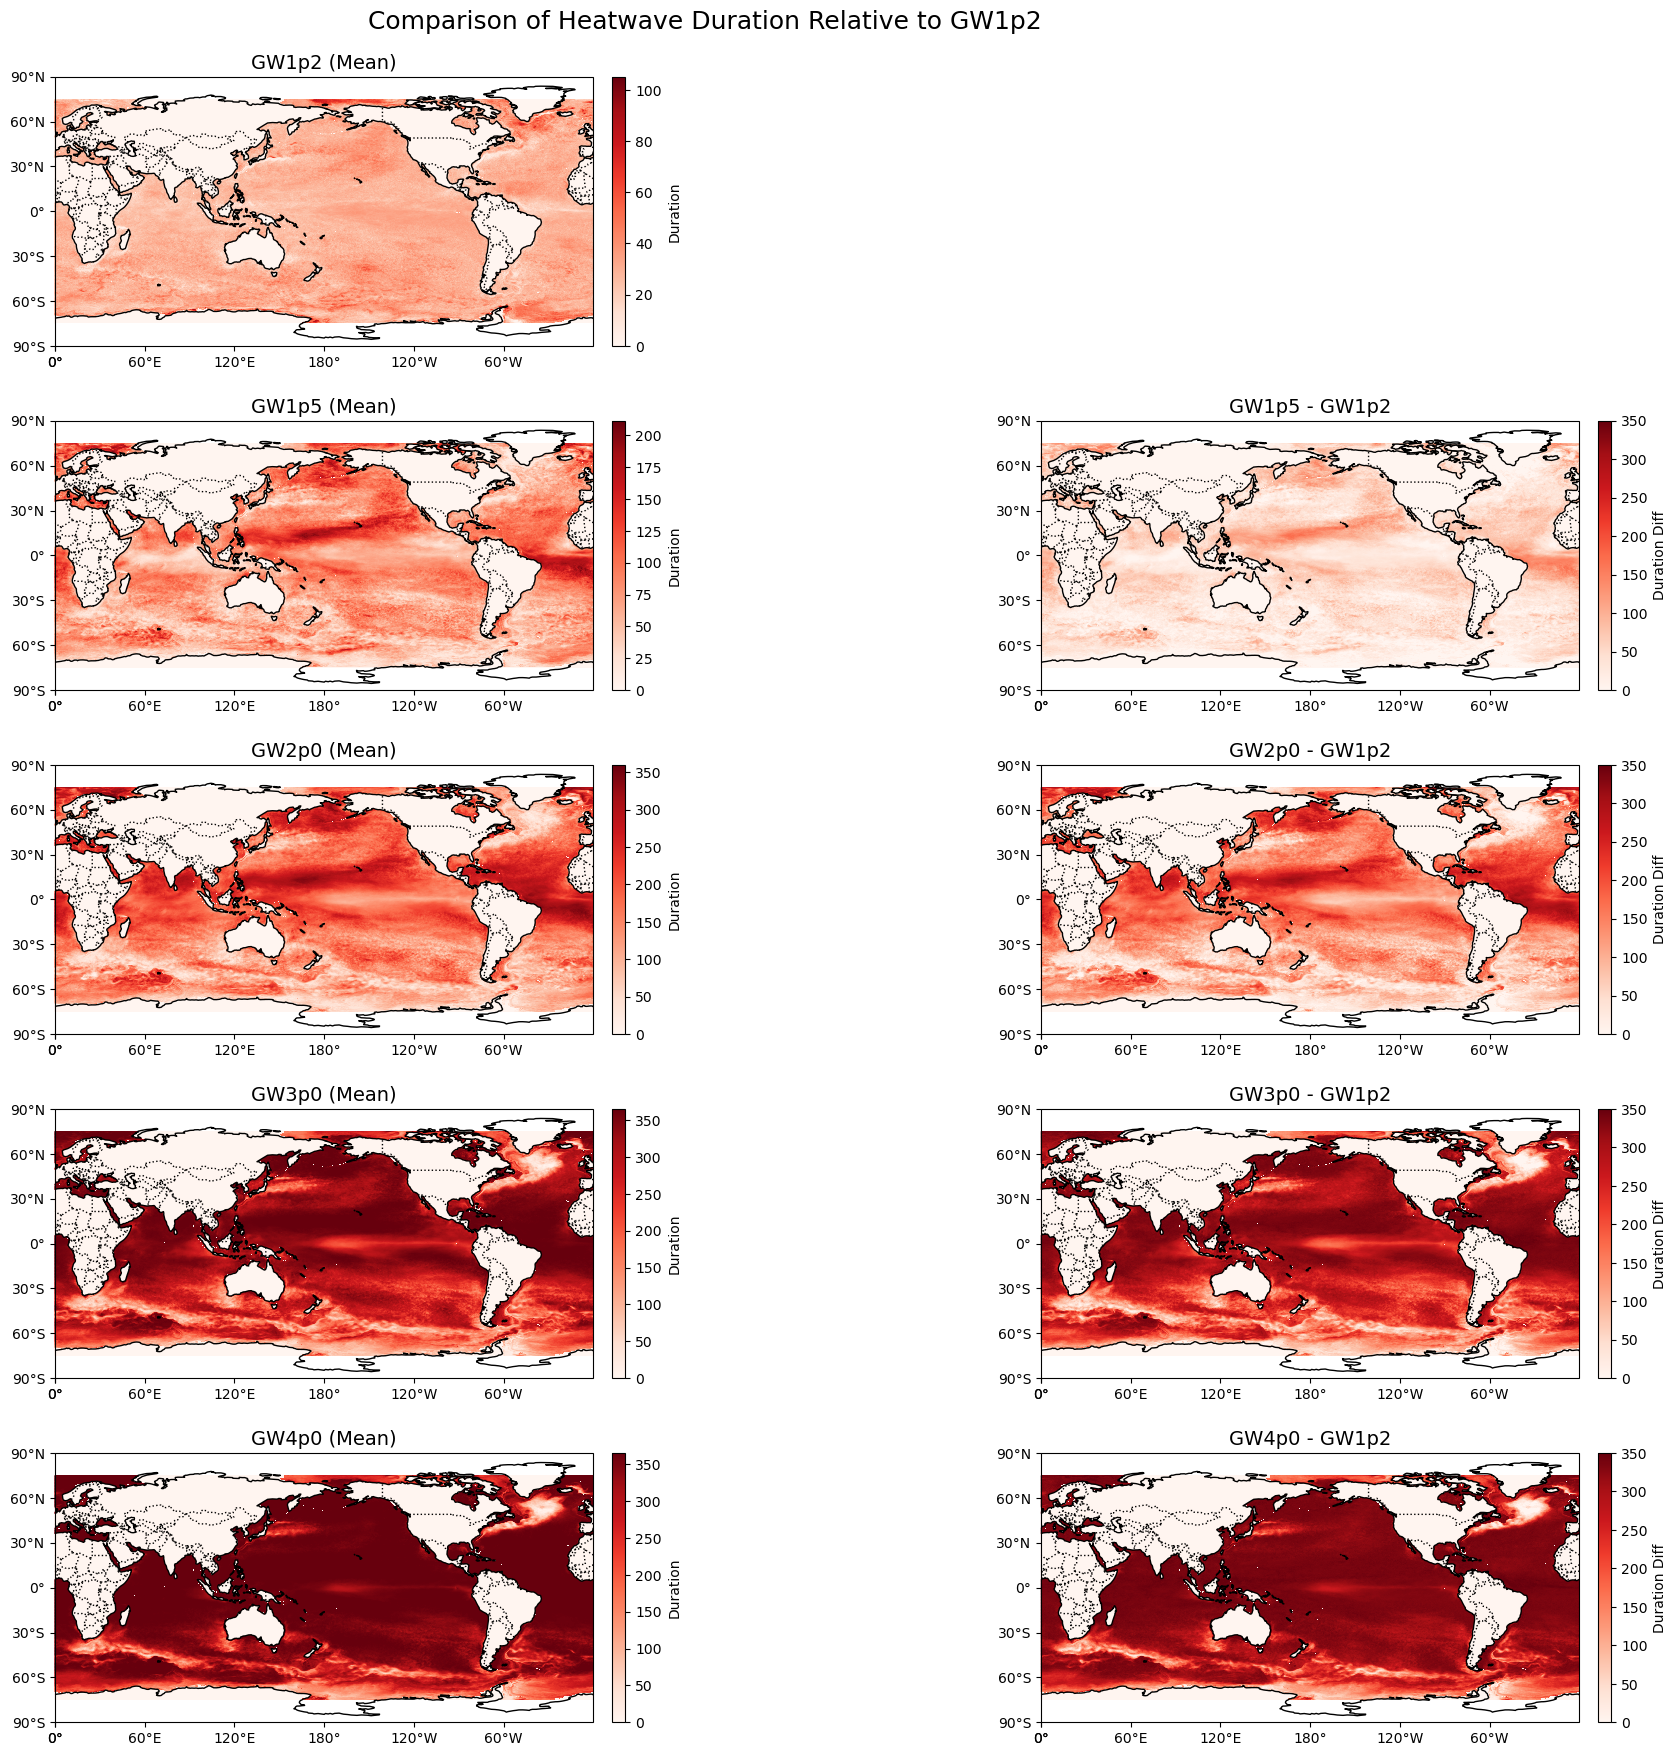

<Figure size 640x480 with 0 Axes>

In [ ]:
def subplots_variable(means, coords, variable, title, color_scales, base_period):
    """
    Create subplots for a specified variable relative to the base period and differences.

    Parameters:
        means (dict): Dictionary with keys as (variable, period) and values as xarray.DataArray of means.
        coords (dict): Dictionary with keys as (variable, period) and values as tuples of longitude and latitude coordinates.
        variable (str): The variable ('duration' or 'magnitude') to plot.
        title (str): The title for the plot.
        color_scales (dict): Dictionary with color scales for each (variable, period) combination.
        base_period (str): The base period for comparison.
    """
    fig, axes = plt.subplots(len(periods), 2, figsize=(20, 18), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    fig.suptitle(title, fontsize=18)

    for i, period in enumerate(periods):
        ax_mean = axes[i, 0]
        
        # Plot mean values
        data = means[(variable, period)]
        vmin, vmax = color_scales[(variable, period)]
        cmap = 'Reds'  # Use 'Reds' colormap for mean values

        lon, lat = coords[(variable, period)]

        # Ensure the data is 2D
        if len(data.shape) == 2 and data.shape == (lat.size, lon.size):
            img_mean = ax_mean.pcolormesh(lon, lat, data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        else:
            raise ValueError(f"Data shape {data.shape} does not match coordinates shape {(lat.size, lon.size)}")

        ax_mean.coastlines()
        ax_mean.add_feature(cfeature.BORDERS, linestyle=':')
        ax_mean.set_title(f'{period} (Mean)', fontsize=14)
        
        # Set ticks and labels for latitude and longitude
        ax_mean.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
        ax_mean.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
        ax_mean.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        ax_mean.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])

        cbar_mean = fig.colorbar(img_mean, ax=ax_mean, orientation='vertical', pad=0.02, fraction=0.05)
        cbar_mean.set_label(variable.capitalize())

        # Plot differences relative to the base period, except for the base period itself
        if period != base_period:
            ax_diff = axes[i, 1]
            diff_data = data - means[(variable, base_period)]
            vmin_diff = 0
            vmax_diff = 350

            if variable == 'magnitude':
                vmax_diff = np.nanmax(np.abs(diff_data.values))  # Adjust vmax for magnitude differences

            if len(diff_data.shape) == 2 and diff_data.shape == (lat.size, lon.size):
                img_diff = ax_diff.pcolormesh(lon, lat, diff_data, cmap=cmap, vmin=vmin_diff, vmax=vmax_diff, transform=ccrs.PlateCarree())
            else:
                raise ValueError(f"Diff data shape {diff_data.shape} does not match coordinates shape {(lat.size, lon.size)}")

            ax_diff.coastlines()
            ax_diff.add_feature(cfeature.BORDERS, linestyle=':')
            ax_diff.set_title(f'{period} - {base_period}', fontsize=14)

            # Set ticks and labels for latitude and longitude
            ax_diff.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
            ax_diff.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
            ax_diff.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
            ax_diff.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])

            cbar_diff = fig.colorbar(img_diff, ax=ax_diff, orientation='vertical', pad=0.02, fraction=0.05)
            cbar_diff.set_label(f'{variable.capitalize()} Diff')

    # Remove the unused subplot in the first row, second column
    fig.delaxes(axes[0, 1])

    plt.tight_layout(pad=2.0)
    plt.show()
    plt.savefig(f'{variable}.png')



# Plotting
subplots_variable(means, coords, 'duration', 'Comparison of Heatwave Duration Relative to GW1p2', color_scales, base_period)
subplots_variable(means, coords, 'magnitude', 'Comparison of Heatwave Magnitude Relative to GW1p2', color_scales, base_period)

In [5]:
# def subplots_variable(means, coords, color_scales, variable, title):
#     """
#     Create subplots for a specified variable relative to the base period.

#     Parameters:
#         means (dict): Dictionary with keys as (variable, period) and values as xarray.DataArray of means.
#         coords (dict): Dictionary with keys as (variable, period) and values as tuples of longitude and latitude coordinates.
#         color_scales (dict): Dictionary with color scales for each variable.
#         variable (str): The variable ('duration' or 'magnitude') to plot.
#         title (str): The title for the plot.
#     """
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(22, 11), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
#     fig.suptitle(title, fontsize=18)

#     vmin, vmax = color_scales[variable]

#     for ax, period, subplot_title in zip([ax1, ax2, ax3, ax4], periods, ['Base Period', 'GW1p5 - GW1p2', 'GW2p0 - GW1p2', 'GW3p0 - GW1p2']):
#         if period == base_period:
#             data = means[(variable, period)]
#         else:
#             data = means[(variable, period)] - means[(variable, base_period)]
       
#         lon, lat = coords[(variable, period)]

        # # Ensure the data is 2D
        # if len(data.shape) == 2 and data.shape == (lat.size, lon.size):
        #     img = ax.pcolormesh(lon, lat, data, cmap='coolwarm', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        # else:
        #     raise ValueError(f"Data shape {data.shape} does not match coordinates shape {(lat.size, lon.size)}")

        # ax.coastlines()
        # ax.add_feature(cfeature.BORDERS, linestyle=':')
        # ax.set_title(subplot_title, fontsize=14)
        
        # # Set ticks and labels for latitude and longitude
        # ax.set_xticks(np.arange(0, 361, 60), crs=ccrs.PlateCarree())
        # ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
        # ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        # ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])

#         # cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
#         cbar.set_label(variable.capitalize())

#     plt.tight_layout()
#     plt.show()

# # Plotting
# subplots_variable(means, coords, color_scales, 'duration', 'Comparison of Heatwave Duration Relative to GW1p2')
# subplots_variable(means, coords, color_scales, 'magnitude', 'Comparison of Heatwave Magnitude Relative to GW1p2')